In [78]:
import psycopg2
import pandas as pd
import numpy as np
from datetime import date,timedelta
import matplotlib.pyplot as plt

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [12]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [13]:
query = """
    select 
        date
        , t.site_id
        , s.site_name 
        , t.device_id
        , d.device_name 
        , d.model
        , d.model_year
        , d.manufacturer_id 
        , t.language
        , t.campaign_id
        , c.campaign_name
        , c.campaign_type_id 
        , app.partner_name as advertiser_name
        , car.partner_name as carrier_name
        , t.mmppartner
        , t.placement_id
        , t.country_code
        , t.metro_code
        , t.homescreen
        , t.sti_type
        , t.billing_type
        , sum(preload) as preload 
        , sum(install) as install 
        , sum(d7_events) as d7_events
        , sum(d7_rev) as d7_rev 
        , sum(spend) as spend 
    from
    (
        select
            date(ctp.tracking_time) as date
            , ctp.site_id
            , ctp.device_id
            , ctp.language
            , ctp.campaign_id
            , ctp.mmppartner
            , ctp.placement_id
            , ctp.country_code
            , ctp.metro_code
            , ctp.homescreen
            , ctp.sti_type
            , ctp.billing_type
            , count(distinct ctp.referrer) as preload
            , 0 as install
            , 0 as d7_events
            , 0 as d7_rev
            , sum(case when billing_type = 'CPP' then gross_payout else 0 end) as spend 
        from rawdata.campaign_tracking_active_preload ctp
        where 
            date(ctp.tracking_time) >= date('{start_date}')
            and date(ctp.tracking_time) <= date('{end_date}')
            and right(ctp.referrer,1) = '0'
        group by 1,2,3,4,5,6,7,8,9,10,11,12

        union all

        select
            date(cti.tracking_time) as date
            , cti.site_id
            , cti.device_id
            , cti.language
            , cti.campaign_id
            , cti.mmppartner
            , cti.placement_id
            , cti.country_code
            , cti.metro_code
            , cti.homescreen
            , cti.sti_type
            , cti.billing_type
            , 0 as preload
            , count(distinct cti.referrer) as install
            , 0 as d7_events
            , 0 as d7_rev
            , sum(case when billing_type = 'CPI' then gross_payout else 0 end) as spend 
        from rawdata.campaign_tracking_active_install cti 
        where 
            date(cti.tracking_time) >= date('{start_date}')
            and date(cti.tracking_time) <= date('{end_date}')
            and right(cti.referrer,1) = '0'
        group by 1,2,3,4,5,6,7,8,9,10,11,12

        union all 

        select
            date(cti.tracking_time) as date
            , cti.site_id
            , cti.device_id
            , cti.language
            , cti.campaign_id
            , cti.mmppartner
            , cti.placement_id
            , cti.country_code
            , cti.metro_code
            , cti.homescreen
            , cti.sti_type
            , cti.billing_type
            , 0 as preload
            , 0 as install
            , count(distinct pi.referrer) as d7_events
            , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' then event_var else 0::varchar END) as d7_rev
            , 0 as spend 
        from rawdata.pi_data pi 
        join 
        (
            select 
                referrer 
                , tracking_time 
                , cti.site_id
                , cti.device_id
                , cti.language
                , cti.campaign_id
                , cti.mmppartner
                , cti.placement_id
                , cti.country_code
                , cti.metro_code
                , cti.homescreen
                , cti.sti_type
                , cti.billing_type
            from rawdata.campaign_tracking_active_install cti 
            where 
                date(cti.tracking_time) >= date('{start_date}')
                and date(cti.tracking_time) <= date('{end_date}')
                and right(cti.referrer,1) = '0'
            group by 1,2,3,4,5,6,7,8,9,10,11,12,13
        ) cti
            on cti.referrer = pi.referrer
            and pi.event_date <= cti.tracking_time + interval '7 day' 
            and pi.event_date >= cti.tracking_time      
        where 
            date(event_date) >= date('{start_date}')
            and date(event_date) <= date('{end_date}') + interval '7 day' 
            and right(pi.referrer,1) = '0'
            and (lower(pi.event) like '%purchase%'
                or lower(pi.event) like '%order%'
                or lower(pi.event) like '%revenue%'
                or (event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$'
                and event_var != 0)) 
            and lower(pi.event) not like '%reorder%'
            and lower(pi.event) not like '%refund%'
            and lower(pi.event) not like '%cancel%'
        group by 1,2,3,4,5,6,7,8,9,10,11,12
    ) t
    left join rawdata.site s 
        on t.site_id = s.site_id
    join rawdata.campaign c
        on c.campaign_id = t.campaign_id
        and c.bid_price_per_download > 0
    left join rawdata.device d
        on t.device_id = d.device_id 
    left join rawdata.partner_app pa 
        on c.app_id = pa.id
    left join rawdata.partner_information app
        on pa.partner_id = app.partner_id
    left join rawdata.partner_information car
        on s.partner_id = car.partner_id 
    group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
;
"""

In [14]:
start_date = '2021-02-09'
end_date = '2021-03-07'
df_list = []

for dt in pd.date_range(start = start_date, end = end_date, freq = '3D'):
    start_dt = dt.strftime('%Y-%m-%d')
    end_dt = min(end_date,(dt+timedelta(days = 2)).strftime('%Y-%m-%d'))
    print('Running query for date range:',start_dt, end_dt)
    try:
        cur_atlas.execute(query.format(start_date = start_dt, end_date = end_dt))
        df_list.append(pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description]))
    except Exception as e:
        print('Error with date range:', start_dt, end_dt)
        print(e)

df = pd.concat(df_list)
df

Running query for date range: 2021-02-26 2021-02-28
Running query for date range: 2021-03-01 2021-03-03
Running query for date range: 2021-03-04 2021-03-06
Running query for date range: 2021-03-07 2021-03-07


date  site_id  \
0       2021-02-08    10361   
1       2021-02-09    12077   
2       2021-02-09    12145   
3       2021-02-09    11906   
4       2021-02-09    11543   
...            ...      ...   
110972  2021-03-07    11531   
110973  2021-03-07    11738   
110974  2021-03-07     9371   
110975  2021-03-07    12121   
110976  2021-03-07    12459   

                                                site_name  device_id  \
0       DT - Bouygues Telecom - FR - Ignite - Samsung ...       7265   
1       DT - Verizon - US - Ignite - Samsung - Galaxy ...       7265   
2               DT - Tracfone - Ignite - Samsung - S111DL       7265   
3                    DT - Samsung - RO - Ignite - AppList       7265   
4       DT - Verizon - US - Ignite - ZTE - Blade Vanta...       7265   
...                                                   ...        ...   
110972                                       DT SingleTap       4520   
110973          DT - Tracfone - Ignite - Samsung - S102DL       4520   
110974        DT - DTOM - VZW - US - Ignite - All Devices       4520   
110975  DT - Verizon - US - Ignite - LG - Velvet 5G - ...       4520   
110976  DT - Xiaomi - IN - Ignite - Redmi Note 9 Pro M...       4520   

       device_name model model_year manufacturer_id language  campaign_id  \
0             None  None       None            None       en        30326   
1             None  None       None            None       en        27748   
2             None  None       None            None       en        29019   
3             None  None       None            None       en        32424   
4             None  None       None            None       en        27748   
...            ...   ...        ...             ...      ...          ...   
110972        None  None       None            None       en        33332   
110973        None  None       None            None       en        32428   
110974        None  None       None            None       en        24326   
110975        None  None       None            None       en        29675   
110976        None  None       None            None       en        32718   

        ... country_code  metro_code homescreen         sti_type billing_type  \
0       ...           FR         NaN      False   Not Single Tap          CPP   
1       ...           US       511.0      False   Not Single Tap          CPI   
2       ...           US       752.0       True   Not Single Tap          CPI   
3       ...           IT         NaN      False   Not Single Tap          CPI   
4       ...           US       737.0      False   Not Single Tap          CPI   
...     ...          ...         ...        ...              ...          ...   
110972  ...           US       609.0      False  true STI (TSTI)          CPI   
110973  ...           US       611.0      False   Not Single Tap          CPI   
110974  ...           US       533.0      False   Not Single Tap          CPI   
110975  ...           US       504.0      False   Not Single Tap          CPP   
110976  ...           IN         NaN      False   Not Single Tap          CPI   

        preload install  d7_events  d7_rev   spend  
0             7       0          0       0  1.7500  
1             2       0          0       0  0.0000  
2             3       0          0       0  0.0000  
3             1       0          0       0  0.0000  
4             1       0          0       0  0.0000  
...         ...     ...        ...     ...     ...  
110972        0       1          0       0  1.2000  
110973        0       1          0       0  3.2900  
110974        0       1          0       0  1.0000  
110975        0       1          0       0  0.0000  
110976        0       1          0       0  0.1500  

[3290171 rows x 26 columns]

In [15]:
df['d7_rev'] = df['d7_rev'].astype('float64')
df['spend'] = df['spend'].astype('float64')

df.dtypes

date                 object
site_id               int64
site_name            object
device_id             int64
device_name          object
model                object
model_year           object
manufacturer_id      object
language             object
campaign_id           int64
campaign_name        object
campaign_type_id      int64
advertiser_name      object
carrier_name         object
mmppartner           object
placement_id          int64
country_code         object
metro_code          float64
homescreen             bool
sti_type             object
billing_type         object
preload               int64
install               int64
d7_events             int64
d7_rev              float64
spend               float64
dtype: object

In [101]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','sti_type','billing_type']


i = 'carrier_name'
pvt = df.pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install       spend  d7_events  \
carrier_name                                                          
DT Verizon                  1074000   120538  551554.500        578   
DT AT&T                      780294   104312  402011.889        533   
DT Tracfone                  783925   128505  245830.569        479   
DT Samsung                  1663686   432366  219795.594       1991   
DT Cricket                   786888   130990  210708.523        611   
DT SingleTap                 394753    85417  133966.850          0   
DT Carrier Unallocated      2281083   455204   76684.476        503   
DT US Cellular               164313    26512   69855.663        105   
DT America Movil MX         1479138   297916   61239.460         30   
DT Bouygues Telecom           52606    10509    7839.650         44   
DT America Movil CO          122615    44483    7589.480         12   
DT Xiaomi                    193154    39193    5545.880          9   
DT Blu                        93497    20041    5348.346          3   
DT TIM                        24534     5958    4645.950         12   
DT Razer                          0     2649    3406.090          9   
DT Sliide                     14322     1713    2929.170          2   
DT America Movil BR           31701     6836    2856.350        245   
DT Lenovo                    123644    25571    2806.950         15   
DT America Movil PE           66075    16678    2326.114          2   
DT Lava                       69216    17023    1749.080          1   
DT InMobi - Pinsight Media        4      451    1736.650          3   
DT America Movil PR           13419     2113    1634.640         14   
DT America Movil CL           12801     2922    1584.794          2   
DT iTel                       66035    15274    1470.040          0   
DT Millicom                   78751    20544    1439.700          2   
DT AT&T Mexico                18795     3864    1008.120          2   
DT Telefonica                  3882      743     938.760          3   
DT Gionee                     49595    10865     910.920          0   
DT Reliance                   63089     7591     632.180          0   
DT America Movil GT           22926     6824     630.740          0   

                                 d7_cpa    d7_rev   d7_roas  
carrier_name                                                 
DT Verizon                   954.246540   43099.0  0.078141  
DT AT&T                      754.243694   31373.0  0.078040  
DT Tracfone                  513.216219   30175.0  0.122747  
DT Samsung                   110.394573  112475.0  0.511725  
DT Cricket                   344.858466   42966.0  0.203912  
DT SingleTap                        inf       0.0  0.000000  
DT Carrier Unallocated       152.454227   36667.0  0.478154  
DT US Cellular               665.292029    8229.0  0.117800  
DT America Movil MX         2041.315333     303.0  0.004948  
DT Bouygues Telecom          178.173864    2376.0  0.303075  
DT America Movil CO          632.456667     186.0  0.024508  
DT Xiaomi                    616.208889     177.0  0.031916  
DT Blu                      1782.782000       3.0  0.000561  
DT TIM                       387.162500    1252.0  0.269482  
DT Razer                     378.454444     117.0  0.034350  
DT Sliide                   1464.585000       0.0  0.000000  
DT America Movil BR           11.658571   25314.0  8.862359  
DT Lenovo                    187.130000     282.0  0.100465  
DT America Movil PE         1163.057000      12.0  0.005159  
DT Lava                     1749.080000       6.0  0.003430  
DT InMobi - Pinsight Media   578.883333      51.0  0.029367  
DT America Movil PR          116.760000     639.0  0.390912  
DT America Movil CL          792.397000      51.0  0.032181  
DT iTel                             inf       0.0  0.000000  
DT Millicom                  719.850000      54.0  0.037508  
DT AT&T Mexico               504.060000     156.0  0.154743  
DT Telefonica      

In [152]:
pvt = df.pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = 'advertiser_name', aggfunc = np.sum)
pvt.sort_values('spend', ascending = False, inplace = True)
pvt['spend_sov'] = 10*pvt['spend']/pvt['spend'].sum()
pvt['pct_valid'] = np.cumsum(pvt['d7_events'] > 0)/np.cumsum(pvt['spend'] > 0)
pvt['has_events'] = pvt.d7_events > 0
available_advertisers = pvt[pvt.has_events].index.to_list()
pvt.groupby('has_events').count()

d7_events  d7_rev  install  preload  spend  spend_sov  pct_valid
has_events                                                                  
False             179     179      179      179    179        179        179
True               48      48       48       48     48         48         48

Text(0.5, 1.0, 'Top Spending Advertisers also are most likely to pass rev events')

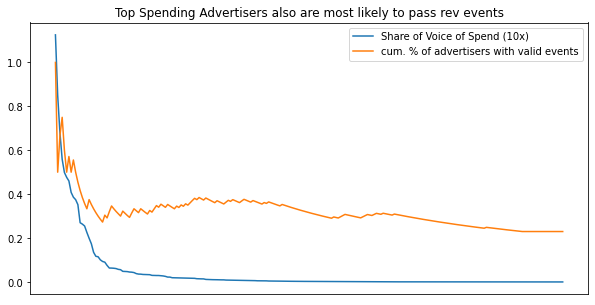

In [140]:
ax = plt.figure(figsize = (10,5)).gca()
ax.axes.xaxis.set_visible(False)
plt.plot(pvt[['spend_sov', 'pct_valid']].sort_values(['spend_sov'],ascending=False))
plt.legend(['Share of Voice of Spend (10x)', 'cum. % of advertisers with valid events'])
plt.title('Top Spending Advertisers also are most likely to pass rev events')

In [95]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','sti_type','billing_type']


i = 'advertiser_name'
pvt = df.pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install       spend  d7_events  \
advertiser_name                                                            
King.com                         1427868   201458  228970.310        616   
Particle Media                    366656    84895  172831.790          0   
GSN Games                         269525    38645  138293.260        192   
Playtika                          292398    35165  113670.540        227   
SmartNews Inc.                    257575    43854  101434.202          0   
TripleDot Studios                 305085    53273   96936.820          0   
Gram Games Limited                184797    27677   93562.910        146   
PlaySimple Games Pte Ltd          286336    53114   82977.650          0   
Wish                              619782   116039   78531.370       1399   
TikTok- BR                        247742    68915   76250.240          0   
Pandora                           188853    34880   71641.180          0   
Peak Games                        149651    21082   54885.710          0   
Moon Active                       137941    18913   53588.690          0   
AOL                               170390        0   51826.400          0   
PlayStudios                       132366    20092   45914.180          0   
EA Mobile                          59921     1827   40482.300         11   
Plarium Global Ltd.                34278     2900   35395.870          0   
Snapchat                          470240   156467   27449.720          0   
Joyo Technology PTE. LTD.         192050    47660   23786.650          0   
Scopely                            37830     2460   23332.488          0   
Curated Content LTD                84820    15371   20487.990          0   
Tiktok LATAM                      171995    46437   18974.400          0   
Rovio Entertainment Corporation    27194     3741   18320.840         28   
Pinterest                          65107    14459   15333.210          0   
WB Games                           23834      540   12884.720          2   
Product Madness                    27648     3453   12841.890         15   
Azur Interactive Games Limited    513638   150760   12688.220          0   
PlutoTV                            50797     7691   12402.150          0   
Opera Norway As                    33970     5238   11673.500          0   
TikTok Inc.                        32895     7292   11370.810          0   

                                      d7_cpa    d7_rev   d7_roas  
advertiser_name                                                   
King.com                          371.705049   24835.0  0.108464  
Particle Media                           inf       0.0  0.000000  
GSN Games                         720.277396   15789.0  0.114170  
Playtika                          500.751278    7867.0  0.069209  
SmartNews Inc.                           inf       0.0  0.000000  
TripleDot Studios                        inf       0.0  0.000000  
Gram Games Limited                640.841849       0.0  0.000000  
PlaySimple Games Pte Ltd                 inf       0.0  0.000000  
Wish                               56.133931  143514.0  1.827474  
TikTok- BR                               inf       0.0  0.000000  
Pandora                                  inf       0.0  0.000000  
Peak Games                               inf       0.0  0.000000  
Moon Active                              inf       0.0  0.000000  
AOL                                      inf       0.0  0.000000  
PlayStudios                              inf       0.0  0.000000  
EA Mobile                        3680.209091    1392.0  0.034385  
Plarium Global Ltd.                      inf       0.0  0.000000  
Snapchat                                 inf       0.0  0.000000  
Joyo Technology PTE. LTD.                inf       0.0  0.000000  
Scopely                                  inf       0.0  0.000000  
Curated Content LTD                      inf       0.0  0.000000  
Tiktok LATAM                             inf       0.0  0.0

In [156]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','sti_type','billing_type']


i = 'billing_type'
filters = (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install      spend  d7_events      d7_cpa    d7_rev  \
billing_type                                                                 
CPI           3565161   632188  595439.89       4907  121.344995  315046.0   
CPP            503484    60780  248472.67        455  546.093780   23947.0   

               d7_roas  
billing_type            
CPI           0.529098  
CPP           0.096377

In [160]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','sti_type','billing_type']


i = 'site_name'
filters = (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install  \
site_name                                                              
DT - Verizon - US - Ignite - Samsung - Galaxy S...    33126     3336   
DT - Verizon - US - Ignite - Samsung - Galaxy S...    31742     3039   
DT - ATT - US - Ignite - Samsung - Galaxy S21 5...    32852     2623   
DT - ATT - US - Ignite - Samsung - Galaxy S21 U...    29546     2281   
DT - Verizon - US - Ignite - Samsung - Galaxy S...    20337     2082   
DT SingleTap                                          30011     5983   
DT - Cricket - US - Ignite - LG - Stylo 6 - LM-...    43814     6763   
DT - Samsung - BR - Ignite - Tier 3 - Silent         349316    63379   
DT - ATT - US - Ignite - Samsung - Galaxy S21+ ...    17276     1505   
DT - ATT - US - Ignite - Samsung - Galaxy A11 -...    26696     2792   
DT - ATT - US - Ignite - Samsung - Galaxy S20 5...    20809     2503   
DT - Cricket - US - Ignite - Samsung - A01 - SM...    31476     4481   
DT - AMX - MX - Ignite                               267800    46589   
DT - Verizon - US - Ignite - Samsung - A51 - SM...    15172     2288   
DT - Samsung - BR - Ignite - Tier 3 - AppList        104153    26172   
DT - Verizon - US - Ignite - Samsung Galaxy Not...     9424     1223   
DT - Tracfone - Ignite - Samsung - S102DL             21164     2534   
DT - DTOM - AMX - MX - Ignite - All Device           260639    52887   
DT - Tracfone - Ignite - LG - L322DL                  31077     3450   
DT - Tracfone - Ignite - Samsung - S111DL             24179     3074   
DT - ATT - US - Ignite - LG - Phoenix 5 -  K300...    11500     2308   
DT - ATT - US - Ignite - Samsung - Galaxy Note ...     8795      773   
DT - Verizon - US - Ignite - Samsung - Galaxy S...     8240     1260   
DT - Cricket - US - Ignite - Samsung - A11 - SM...    19664     2337   
DT - Tracfone - Ignite - LG - L722DL                  14460     1806   
DT - Verizon - US - Ignite - Samsung Galaxy Not...     6600      903   
DT - Samsung - DE - Ignite - Tier 1 - AppList         13363     3440   
DT - Cricket - US - Ignite - LG - Fortune 3 - L...    19460     3171   
DT - Samsung - IT - Ignite - A-Series - AppList       21468     4808   
DT - Verizon - US - Ignite - LG - V60 ThinQ 5G ...     7581     1083   

                                                       spend  d7_events  \
site_name                                                                 
DT - Verizon - US - Ignite - Samsung - Galaxy S...  34181.96         46   
DT - Verizon - US - Ignite - Samsung - Galaxy S...  33045.03         49   
DT - ATT - US - Ignite - Samsung - Galaxy S21 5...  24748.27         30   
DT - ATT - US - Ignite - Samsung - Galaxy S21 U...  23153.22         36   
DT - Verizon - US - Ignite - Samsung - Galaxy S...  22152.71         36   
DT SingleTap                                        21097.05          0   
DT - Cricket - US - Ignite - LG - Stylo 6 - LM-...  18731.00        147   
DT - Samsung - BR - Ignite - Tier 3 - Silent        15119.56        672   
DT - ATT - US - Ignite - Samsung - Galaxy S21+ ...  13741.53         23   
DT - ATT - US - Ignite - Samsung - Galaxy A11 -...  12328.51         42   
DT - ATT - US - Ignite - Samsung - Galaxy S20 5...  11961.12         34   
DT - Cricket - US - Ignite - Samsung - A01 - SM...  10365.69         46   
DT - AMX - MX - Ignite                               9961.79         27   
DT - Verizon - US - Ignite - Samsung - A51 - SM...   9176.01         19   
DT - Samsung - BR - Ignite - Tier 3 - AppList        8748.04        227   
DT - Verizon - US - Ignite - Samsung Galaxy Not...   8719.75         18   
DT - Tracfone - Ignite - Samsung - S102DL            8282.92         48   
DT - DTOM - AMX - MX - Ignite - All Device           8148.16        223   
DT - Tracfone - Ignite - LG - L322DL                 8046.31         33   
DT - Tracfone - Ignite - Samsung - S111DL            8024.67         37   
DT - ATT - US - Ignite - LG - Phoenix 5 -  K300...   7642.00         24   
DT - ATT - US - Ignite

In [157]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','sti_type','billing_type']


i = 'placement_id'
filters = (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install      spend  d7_events      d7_cpa    d7_rev  \
placement_id                                                                 
1             3661056   646284  761193.79       5036  151.150475  318910.0   
97             253817    31678   43784.57        190  230.445105   12661.0   
99             137185    10256   38367.40        135  284.202963    7422.0   
2               16587     4750     566.80          1  566.800000       0.0   

               d7_roas  
placement_id            
1             0.418960  
97            0.289166  
99            0.193445  
2             0.000000

In [161]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','sti_type','billing_type']


i = 'country_code'
filters = (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install      spend  d7_events       d7_cpa    d7_rev  \
country_code                                                                  
US            1600683   194018  716714.24       2466   290.638378  168809.0   
BR             667774   128702   35660.47       2152    16.570850  138945.0   
MX             677577   120081   22049.18         75   293.989067    1146.0   
DE              30153     7192   11860.61        123    96.427724    3360.0   
CO             211936    55469    7935.69         30   264.523000    3750.0   
IT              31238     7110    7900.96         43   183.743256    3712.0   
FR              42199     7941    6474.74         63   102.773651    5919.0   
GB              16234     2850    4533.87         51    88.899412    4292.0   
TR              20391     5123    3185.26         12   265.438333     414.0   
NL               9842     1600    2709.30         28    96.760714    2586.0   
PE             140632    31733    2534.61          5   506.922000      21.0   
IN             111755    22242    2514.43          2  1257.215000       6.0   
CL              40675     6918    2057.41         21    97.971905    1089.0   
ES              12587     2519    1834.13          5   366.826000      15.0   
AR              17861     5138    1352.82          7   193.260000      96.0   
BE               8844     1563    1314.72         13   101.132308    1005.0   
PL              11127     2349     802.59         12    66.882500     816.0   
PR               7891     1239     704.42         14    50.315714     639.0   
RO               7732     1460     698.24          9    77.582222      42.0   
DO              40358    10486     621.13          1   621.130000       0.0   
SE               4416      464     562.84          4   140.710000      51.0   
CH               1694      379     534.39          9    59.376667     678.0   
VE              17348     3882     472.98          0          inf       0.0   
PT               4448      955     458.13          2   229.065000     138.0   
EC              22425     4697     449.44          2   224.720000      24.0   
HN              33328     9157     430.59          0          inf       0.0   
SV              33050     7550     410.99          0          inf       0.0   
GT              34651     9996     386.40          1   386.400000      24.0   
DK               2649      327     362.83          2   181.415000     297.0   
EG              10373     2201     347.84          4    86.960000      90.0   

               d7_roas  
country_code            
US            0.235532  
BR            3.896331  
MX            0.051975  
DE            0.283291  
CO            0.472549  
IT            0.469816  
FR            0.914168  
GB            0.946653  
TR            0.129974  
NL            0.954490  
PE            0.008285  
IN            0.002386  
CL            0.529306  
ES            0.008178  
AR            0.070963  
BE            0.764421  
PL            1.016708  
PR            0.907129  
RO            0.060151  
DO            0.000000  
SE            0.090612  
CH            1.268736  
VE            0.000000  
PT            0.301225  
EC            0.053400  
HN            0.000000  
SV            0.000000  
GT            0.062112  
DK            0.818565  
EG            0.258740

In [167]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id','sti_type',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','billing_type']


i = ['metro_code']
filters = (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install     spend  d7_events      d7_cpa  d7_rev  \
metro_code                                                              
623.0         45315     5290  19720.47         79  249.626203  3952.0   
803.0         39278     4434  15982.80         35  456.651429  1667.0   
501.0         36095     4047  14996.25         36  416.562500  1483.0   
602.0         31527     3504  12682.11         41  309.319756  1686.0   
618.0         34004     4289  12625.01         49  257.653265  2520.0   
524.0         28662     3641  11696.48         39  299.909744  3881.0   
534.0         20124     2325   9150.68         21  435.746667  1113.0   
753.0         26287     3084   9005.67         49  183.789184  2807.0   
511.0         18563     2073   8388.96         23  364.737391   651.0   
504.0         18450     2244   7964.44         28  284.444286   581.0   
807.0         15768     1777   7763.97         14  554.569286   963.0   
517.0         17768     2385   7359.11         30  245.303667  1026.0   
539.0         19148     2299   7223.16         36  200.643333  1137.0   
510.0         14139     1712   6628.74         23  288.206087   750.0   
751.0         17080     1810   6351.52         25  254.060800   780.0   
862.0         15248     1947   6282.72         16  392.670000  1041.0   
819.0         17275     1797   6276.03         30  209.201000  1848.0   
659.0         15814     1947   6095.74         28  217.705000  1182.0   
609.0         12963     1612   5551.14         33  168.216364  1089.0   
527.0         14140     1669   5499.10         23  239.091304   566.0   
560.0         12943     1784   5460.22         15  364.014667  3218.0   
640.0         12874     1920   5332.60         21  253.933333  1393.0   
613.0         14179     1547   5211.29         21  248.156667  4038.0   
505.0         11545     1254   5129.47         15  341.964667   423.0   
641.0         13839     1637   5043.28         16  315.205000  1228.0   
630.0         10903     1659   4920.53         24  205.022083   690.0   
567.0         11873     1657   4871.99         18  270.666111   933.0   
693.0         11479     1692   4756.75         32  148.648437  2280.0   
650.0         11089     1423   4696.93         22  213.496818  1074.0   
637.0         10947     1403   4661.88          8  582.735000   282.0   

             d7_roas  
metro_code            
623.0       0.200401  
803.0       0.104300  
501.0       0.098891  
602.0       0.132943  
618.0       0.199604  
524.0       0.331809  
534.0       0.121630  
753.0       0.311693  
511.0       0.077602  
504.0       0.072949  
807.0       0.124034  
517.0       0.139419  
539.0       0.157410  
510.0       0.113144  
751.0       0.122805  
862.0       0.165693  
819.0       0.294454  
659.0       0.193906  
609.0       0.196176  
527.0       0.102926  
560.0       0.589354  
640.0       0.261223  
613.0       0.774856  
505.0       0.082465  
641.0       0.243492  
630.0       0.140229  
567.0       0.191503  
693.0       0.479319  
650.0       0.228660  
637.0       0.060491

In [162]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id','sti_type',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','billing_type']


i = ['sti_type']
filters = (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install      spend  d7_events  \
sti_type                                                            
Not Single Tap             4018712   684377  817560.68       5339   
true STI (TSTI)              37455     6476   21441.80          7   
Regular STI (Traditional)    12478     2115    4910.08         16   

                                d7_cpa    d7_rev   d7_roas  
sti_type                                                    
Not Single Tap              153.129927  337148.0  0.412383  
true STI (TSTI)            3063.114286     348.0  0.016230  
Regular STI (Traditional)   306.880000    1497.0  0.304883

In [163]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id','sti_type',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','billing_type']


i = ['homescreen']
filters = (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install      spend  d7_events      d7_cpa    d7_rev  \
homescreen                                                                 
False       3931600   672439  803028.63       5016  160.093427  308206.0   
True         137045    20529   40883.93        346  118.161647   30787.0   

             d7_roas  
homescreen            
False       0.383804  
True        0.753034

In [159]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','sti_type','billing_type']

i = ['carrier_name','site_name']
filters = (df.advertiser_name == 'Wish') & (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  \
carrier_name           site_name                                                     
DT Samsung             DT - Samsung - BR - Ignite - Tier 3 - Silent         151432   
DT Carrier Unallocated DT - DTOM - AMX - MX - Ignite - All Device            44908   
                       DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD          54668   
DT Cricket             DT - Cricket - US - Ignite - LG - Stylo 6 - LM-...     6834   
DT AT&T                DT - ATT - US - Ignite - Samsung - Galaxy A11 -...     5239   
DT Samsung             DT - Samsung - IT - Ignite - A-Series - AppList        5659   
DT SingleTap           DT SingleTap                                           5143   
DT Verizon             DT - Verizon - US - Ignite - Samsung - Galaxy S...     2352   
DT Samsung             DT - Samsung - UK - Ignite - A-Series - AppList        3144   
DT Tracfone            DT - Tracfone - Ignite - LG - L322DL                   4617   
DT Verizon             DT - Verizon - US - Ignite - Samsung - Galaxy S...     1938   
DT Cricket             DT - Cricket - US - Ignite - Samsung - A01 - SM...     4509   
DT Tracfone            DT - Tracfone - Ignite - Samsung - S102DL              2737   
DT Cricket             DT - Cricket - US - Ignite - LG - Fortune 3 - L...     3866   
DT Tracfone            DT - Tracfone - Ignite - Motorola - XT2005DL           3453   
                       DT - Tracfone - Ignite - Samsung - S111DL              3660   
DT AT&T                DT - ATT - US - Ignite - LG - Phoenix 5 -  K300...     2274   
DT Verizon             DT - Verizon - US - Ignite - Motorola - E6             2373   
DT Carrier Unallocated DT - DTOM - VZW - US - Ignite - All Devices            5962   
DT Tracfone            DT - Tracfone - Ignite - Blu - B100DL                  3308   
DT Cricket             DT - Cricket - US - Ignite - Samsung - A11 - SM...     3840   
DT AT&T                DT - ATT - US - Ignite - Samsung - Galaxy S20 5...     2066   
DT Samsung             DT - Samsung - DE - Ignite - Tier 1 - AppList          2042   
DT Verizon             DT - Verizon - US - Ignite - ZTE - Blade Vantag...     2491   
DT Cricket             DT - Cricket - US - Ignite - LG - K92 5G - LM-K...     2701   
DT Samsung             DT - Samsung - BR - Ignite - Tier 2 - Silent          17550   
                       DT - Samsung - BR - Ignite - Tier 1 - Silent          15732   
                       DT - Samsung - NL - Ignite - A-Series - AppList        2200   
DT Carrier Unallocated DT - DTOM - VZW OM - US - Ignite - RDNS BYOD           3147   
                       DT - DTOM - AMX - Non MX - Ignite - RDNS BYOD          9518   

                                                                           install  \
carrier_name           site_name                                                     
DT Samsung             DT - Samsung - BR - Ignite - Tier 3 - Silent          33164   
DT Carrier Unallocated DT - DTOM - AMX - MX - Ignite - All Device             8411   
                       DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD           9333   
DT Cricket             DT - Cricket - US - Ignite - LG - Stylo 6 - LM-...     1382   
DT AT&T                DT - ATT - US - Ignite - Samsung - Galaxy A11 -...      834   
DT Samsung             DT - Samsung - IT - Ignite - A-Series - AppList        1371   
DT SingleTap           DT SingleTap                                            937   
DT Verizon             DT - Verizon - US - Ignite - Samsung - Galaxy S...      281   
DT Samsung             DT - Samsung - UK - Ignite - A-Series - AppList         660   
DT Tracfone            DT - Tracfone - Ignite - LG - L322DL                    566   
DT Verizon             DT - Verizon - US - Ignite - Samsung - Galaxy S...      237   
DT Cricket             DT - Cricket - US - Ignite - Samsung - A01 - SM...      720   
DT Tracfone            DT - Tracfone - Ignite - Samsung - S102DL               461   
DT Cricket             DT - Cric

In [108]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id','sti_type',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','billing_type']


i = ['campaign_name']
filters = (df.advertiser_name == 'Wish') & (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install  \
campaign_name                                                          
Wish-Android-9425-US-Cricket-Ignite-CPI               48575     7380   
Wish-Android-9425-US-VZW-Ignite-CPI                   35332     4576   
Wish-Android-9425-US-Tracfone-Ignite-CPI              34743     5413   
Wish-Android-9425-US-AT&T-Ignite-CPI                  23195     3735   
Wish-Android-9425-BR-Samsung-Silent-Ignite-CPI       184714    40255   
Wish-Android-9425-US-OM-Ignite-CPI                    19487     2094   
Wish-Android-9425-CO-AMX-Ignite-CPI                   32229     7446   
Wish-Android-9425-MX-AMX-Ignite-CPI                   77148    13178   
Wish-Android-9425-US-S21s-Ignite-CPI                   5677      415   
Wish-Android-9425-MX-OM-Ignite-CPI                    32548     6443   
Wish-Android-9425-US-USCC-Ignite-CPI                   6640      893   
Wish-Android-9425-IT-Samsung-Ignite-CPI                5950     1437   
Wish-Android-9425-DE-Samsung-Ignite-CPI                4010      931   
DT - SingleTap - DSP  Wish - Preload Retargeting       5143      937   
Wish-Android-9425-UK-Samsung-Ignite-CPI                3267      687   
Wish-Android-9425-BR-AMX-Ignite-CPI                   13312     2211   
Wish-Android-9425-FR-Bouygues-Ignite-CPI               8539     1237   
Wish-Android-9425-IT-Ignite-CPI                        3845      785   
Wish-Android-9425-NL-Samsung-Ignite-CPI                2241      477   
Wish-Android-9425-IN-Xiaomi-CPI                       23854     5281   
Wish-Android-9425-CL-AMX-Ignite-CPI                    5925      818   
Wish-Android-9425-Europe-Lenovo-Archos-BLU-Acer...     8154     1016   
Wish-Android-9425-BE-Samsung-Ignite-CPI                1295      289   
Wish-Android-9425-CO-Samsung-Ignite-CPI                3140      889   
Wish-Android-9425-PL-Samsung-Ignite-CPI                2862      640   
Wish-Android-9425-MX-Samsung-Ignite-CPI                2421      544   
Wish-Android-9425-AR-Samsung-Ignite-CPI                5250     1711   
Wish-Android-9425-CL-Samsung-Ignite-CPI                3605      715   
Wish-Android-9425-TR-Samsung-Ignite-CPI                4196     1193   
Wish-Android-9425-CH-Samsung-Ignite-CPI                 467       91   

                                                       spend  d7_events  \
campaign_name                                                             
Wish-Android-9425-US-Cricket-Ignite-CPI             11486.51        293   
Wish-Android-9425-US-VZW-Ignite-CPI                 11307.11        167   
Wish-Android-9425-US-Tracfone-Ignite-CPI             9265.46        206   
Wish-Android-9425-US-AT&T-Ignite-CPI                 8549.82        120   
Wish-Android-9425-BR-Samsung-Silent-Ignite-CPI       8087.60        206   
Wish-Android-9425-US-OM-Ignite-CPI                   3357.63         80   
Wish-Android-9425-CO-AMX-Ignite-CPI                  2964.26         14   
Wish-Android-9425-MX-AMX-Ignite-CPI                  2945.32         21   
Wish-Android-9425-US-S21s-Ignite-CPI                 2410.00         17   
Wish-Android-9425-MX-OM-Ignite-CPI                   2361.13         19   
Wish-Android-9425-US-USCC-Ignite-CPI                 2048.76         41   
Wish-Android-9425-IT-Samsung-Ignite-CPI              2019.20         24   
Wish-Android-9425-DE-Samsung-Ignite-CPI              1633.50         28   
DT - SingleTap - DSP  Wish - Preload Retargeting     1357.25          0   
Wish-Android-9425-UK-Samsung-Ignite-CPI              1236.00         30   
Wish-Android-9425-BR-AMX-Ignite-CPI                   998.78         12   
Wish-Android-9425-FR-Bouygues-Ignite-CPI              919.20         21   
Wish-Android-9425-IT-Ignite-CPI                       778.35         11   
Wish-Android-9425-NL-Samsung-Ignite-CPI               715.50         14   
Wish-Android-9425-IN-Xiaomi-CPI                       530.20          0   
Wish-Android-9425-CL-AMX-Ignite-CPI                   476.65          6   
Wish-Android-9425-Euro

In [109]:
index_list = ['date', 'campaign_name', 'campaign_type_id', 'advertiser_name', 'site_name', 'manufacturer_id','sti_type',
             'carrier_name', 'language', 'mmppartner','placement_id','country_code','metro_code','homescreen','billing_type']


i = ['site_name']
filters = (df.advertiser_name == 'Wish') & (df['advertiser_name'].isin(available_advertisers))
pvt = df[filters].pivot_table(values = ['preload', 'install', 'spend', 'd7_events', 'd7_rev'], index = i, aggfunc = np.sum)
pvt['d7_cpa'] = pvt['spend']/pvt['d7_events']
pvt['d7_roas'] = pvt['d7_rev']/pvt['spend']
pvt[['preload', 'install', 'spend', 'd7_events', 'd7_cpa', 'd7_rev', 'd7_roas']].sort_values(['spend'],ascending=False).head(30)


preload  install    spend  \
site_name                                                                       
DT - Samsung - BR - Ignite - Tier 3 - Silent         151432    33164  6660.20   
DT - DTOM - AMX - MX - Ignite - All Device            44908     8411  4660.14   
DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD          54668     9333  2465.11   
DT - Cricket - US - Ignite - LG - Stylo 6 - LM-...     6834     1382  2073.00   
DT - ATT - US - Ignite - Samsung - Galaxy A11 -...     5239      834  1987.75   
DT - Samsung - IT - Ignite - A-Series - AppList        5659     1371  1920.20   
DT SingleTap                                           5143      937  1357.25   
DT - Verizon - US - Ignite - Samsung - Galaxy S...     2352      281  1270.00   
DT - Samsung - UK - Ignite - A-Series - AppList        3144      660  1187.85   
DT - Tracfone - Ignite - LG - L322DL                   4617      566  1111.90   
DT - Verizon - US - Ignite - Samsung - Galaxy S...     1938      237  1090.50   
DT - Cricket - US - Ignite - Samsung - A01 - SM...     4509      720  1080.00   
DT - Tracfone - Ignite - Samsung - S102DL              2737      461  1041.30   
DT - Cricket - US - Ignite - LG - Fortune 3 - L...     3866      662  1015.35   
DT - Tracfone - Ignite - Motorola - XT2005DL           3453      741  1009.85   
DT - Tracfone - Ignite - Samsung - S111DL              3660      550   989.80   
DT - ATT - US - Ignite - LG - Phoenix 5 -  K300...     2274      402   948.44   
DT - Verizon - US - Ignite - Motorola - E6             2373      324   939.60   
DT - DTOM - VZW - US - Ignite - All Devices            5962      719   909.83   
DT - Tracfone - Ignite - Blu - B100DL                  3308      591   886.50   
DT - Cricket - US - Ignite - Samsung - A11 - SM...     3840      543   879.00   
DT - ATT - US - Ignite - Samsung - Galaxy S20 5...     2066      385   858.10   
DT - Samsung - DE - Ignite - Tier 1 - AppList          2042      476   842.00   
DT - Verizon - US - Ignite - ZTE - Blade Vantag...     2491      326   734.25   
DT - Cricket - US - Ignite - LG - K92 5G - LM-K...     2701      482   723.00   
DT - Samsung - BR - Ignite - Tier 2 - Silent          17550     3556   715.80   
DT - Samsung - BR - Ignite - Tier 1 - Silent          15732     3535   711.60   
DT - Samsung - NL - Ignite - A-Series - AppList        2200      469   703.50   
DT - DTOM - VZW OM - US - Ignite - RDNS BYOD           3147      375   666.94   
DT - DTOM - AMX - Non MX - Ignite - RDNS BYOD          9518     2370   592.50   

                                                    d7_events      d7_cpa  \
site_name                                                                   
DT - Samsung - BR - Ignite - Tier 3 - Silent              139   47.915108   
DT - DTOM - AMX - MX - Ignite - All Device                 36  129.448333   
DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD               10  246.511000   
DT - Cricket - US - Ignite - LG - Stylo 6 - LM-...         59   35.135593   
DT - ATT - US - Ignite - Samsung - Galaxy A11 -...         27   73.620370   
DT - Samsung - IT - Ignite - A-Series - AppList            24   80.008333   
DT SingleTap                                                0         inf   
DT - Verizon - US - Ignite - Samsung - Galaxy S...          7  181.428571   
DT - Samsung - UK - Ignite - A-Series - AppList            28   42.423214   
DT - Tracfone - Ignite - LG - L322DL                       20   55.595000   
DT - Verizon - US - Ignite - Samsung - Galaxy S...          4  272.625000   
DT - Cricket - US - Ignite - Samsung - A01 - SM...         21   51.428571   
DT - Tracfone - Ignite - Samsung - S102DL                  31   33.590323   
DT - Cricket - US - Ignite - LG - Fortune 3 - L...         29   35.012069   
DT - Tracfone - Ignite - Motorola - XT2005DL               23   43.906522   
DT - Tracfone - Ignite - Samsung - S111DL                  19   52.094737   
DT - ATT - US - Ignite - LG - Phoenix 5 -  K300...         13   72.956923